# Fitting an Alex vs. Kelly Model

**Goal:** A classifier that takes an unlabeled image and predicts if it was taken by Alex or Kelly.

**Steps:**

1. Data Preprocessing
    - Already done in `image_processing.ipynb`. Can just copy over transformation of raw images to tensors.
2. Load a pretrained model (ResNet)
    - ResNet is a collection of models already trained on millions of images that is great at picking out textures, objects, and other details from images.
    - ResNet18 (referring to 18 layers) is probably suitable for our 400 images, but we can also try Resnet34 or Resnet50 to compare performance
3. Replace the final layer
    - Current ResNet models have 1000 classes predicted in the output layer
    - We are only predicting 2 classes so we can either:
        - output two scores: Alex vs. Kelly
        - output one score: probability of Alex (or Kelly)
4. Train and Evaluate
    - Option A: train only the replaced layer, keep the rest of ResNet as is
    - Option B: train all or most of the other layers
    - The first option is probably ideal due to much lower computational complexity for only 400 images to reduce overfitting risk, but we can try both if time permits

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import random
import copy
torch.manual_seed(44)
np.random.seed(44)
random.seed(44)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## 1. Data Preprocessing

Mostly copy and pasting from `image_processing.ipynb`

For model training, we now define two separate preprocessing pipelines:

- **Training pipeline:** light data augmentation like random flips and random crops to introduce variation in the images and help the model generalize better

- **Validation pipeline:** more deterministic (resize and normalize only), ensuring evaluations are consistent and comparable across epochs.

Originally, I trained the baseline model using only simple preprocessing and noticed much more overfitting. The training accuracy kept rising while validation accuracy plateaued and began to decline. After adding some augmentation and rerunning the model, the validation performance improved and the train/val gap narrowed.

So, we’ll keep the augmented training pipeline for all remaining experiments.

Define transformation pipelines:

In [2]:
# used ONLY for training set
## some randomness for overfitting purposes
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # random crop and resize
    transforms.RandomHorizontalFlip(p=0.5), # flip left/right
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# used for validation
val_transform = transforms.Compose([
    transforms.Resize((224, 224)), # no randomness
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

80/20 split stratified by label (Alex or Kelly):

In [3]:
# base dataset to get filepaths and labels
base_dataset = datasets.ImageFolder(root="data")  # no transformations yet
paths = [sample[0] for sample in base_dataset.samples]
labels = [sample[1] for sample in base_dataset.samples]

# stratified 80/20 split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# map path to index into base_dataset
path_to_index = {path: idx for idx, (path, _) in enumerate(base_dataset.samples)}
train_indices = [path_to_index[p] for p in train_paths]
val_indices   = [path_to_index[p] for p in val_paths]

# applying training transformation 
train_full = datasets.ImageFolder(root="data", transform=train_transform)

# apply validation transformation
val_full   = datasets.ImageFolder(root="data", transform=val_transform)

# split on the train/test indices made above
train_dataset = Subset(train_full, train_indices)
val_dataset   = Subset(val_full, val_indices)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

print(f"Training samples processed: {len(train_dataset)}")
print(f"Validation samples processed: {len(val_dataset)}")

Training samples processed: 388
Validation samples processed: 97


## 2. Load a Pretrained Model 

A few different versions in case we want to try more:

In [4]:
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V2)

## 3. Replace the Final Layer

Starting with ResNet18, the model has the following structure: 

1. Initial Layers
    - bunch of technical stuff but basically turns images 64 feature maps of lower resolution capturing edges, simple shapes, basic textures
2. Residual Blocks
    - 4 stages, each with 2 residual blocks that learn curves, shadows, object parts, styles
    - each stage has more depth, features, and receptive field (how much of the image it sees) 
3. Global Average Pooling
    - Averages each feature map (512 of them?) from the residual blocks to a single number 
    - Produces a single 512-dimensional feature vector representing the entire image
4. Fully Connected Layer
    - Takes the 512d vector and maps it to 1000 logits representing 1 per class
    - Logits turn into probabilities after softmax

Don't really need to understand the details in much depth to run the models, but may need to do more research to write the report...

The layer we need to replace is the final fully connected layer. We need to map the 512d vector to 2 logits representing Alex and Kelly.

This is the final layer currently:

In [5]:
resnet18.fc # fully connected layer

Linear(in_features=512, out_features=1000, bias=True)

As mentioned, we need out_features to be 2, not 1000.

In [6]:
in_features = resnet18.fc.in_features # keep the number of input features the same
resnet18.fc = torch.nn.Linear(in_features, 2) # change output to 2 classes
resnet18.fc

Linear(in_features=512, out_features=2, bias=True)

## 4. Train the Model

Since cross-validation is not ideal with the computational complexity here, we will use an 80/20 train/test split defined above. If there is too much instability due to sample size, we may have to go back to CV.

Our first method of training will be with only the final layer. So, we will "freeze" all the other layers, meaning they will stay as what ResNet18 was already trained as, and the final layer will be optimized for our outputs.

In [7]:
# freeze all params
for param in resnet18.parameters():
    param.requires_grad = False

# unfreeze final layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

Two other things we need to define before training is the criterion and the optimizer:

- **Criterion:** how wrong is the model?
- **Optimizer:** what do we do to fix it?

For criterion, we will use Cross Entropy Loss because it applies softmax within it, which ResNet will do to our outputted logits, and compares the predicted distribution to the actual labels to penalize for wrong confidence. It's a very standard criterion and works great with our goals.

For optimizer, we will use Adam because it is also very popular, stable, and easy in this type of image classification. Technical details may be useful in the report. The learning rate in Adam can be tuned, but we can just start with a common stable default.

In [8]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=1e-3)

Now some functions for training and evaluation:

In [9]:
# a function for resetting the model - **run before every re-training unless you want to continue a previous training**
def new_resnet18():
    resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = resnet18.fc.in_features
    resnet18.fc = torch.nn.Linear(in_features, 2)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=1e-3)
    return resnet18, loss, optimizer

# function for full training and validation with some early stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):

    # store results per epoch
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    # keep track of best model state by validation accuracy
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_state_dict = None

    # keep track of epoch improvement for early stopping
    epochs_no_improve = 0

    for epoch in range(num_epochs):

        # TRAINING PHASE

        model.train() # puts the model in 'train mode'
        running_loss = 0.0
        correct = 0
        total = 0

        # iterate over data loader batches. treat each batch independently 
        ## basically do one update per batch per epoch (stochastic gradient descent)
        for X_batch, y_batch in train_loader:

            optimizer.zero_grad() # reset gradients

            outputs = model(X_batch) # forward pass
            loss = criterion(outputs, y_batch)

            loss.backward() # backward pass
            optimizer.step() # update weights

            # accumulate stats
            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * X_batch.size(0) # loss.item() is the avg loss per sample so multiply by batch size
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        # compute full epoch stats
        train_loss = running_loss / total
        train_acc = correct / total

        # VALIDATION PHASE

        model.eval() # puts the model in 'eval mode'
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)

                # accumulate stats
                preds = outputs.argmax(dim=1)
                val_running_loss += loss.item() * X_batch.size(0)
                val_correct += (preds == y_batch).sum().item()
                val_total += y_batch.size(0)
        
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total

        # store epoch results
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # track best model and early stopping check
        if val_loss < best_val_loss - 0.001:
            best_val_loss = val_loss
            best_state_dict = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

            if epochs_no_improve >= 5:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
        
        # print epoch summary as progress
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # load best model state and return
    model.load_state_dict(best_state_dict)
    return model, history

# plot train vs val loss
def plot_loss_history(history):

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(5, 3))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Val Loss', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# plot train vs val accuracy
def plot_accuracy_history(history):

    epochs = range(1, len(history['train_acc']) + 1)

    plt.figure(figsize=(5, 3))
    plt.plot(epochs, history['train_acc'], label='Train Accuracy', marker='o')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
resnet18, loss, optimizer = new_resnet18()
trained_model, history = train_model(resnet18, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Epoch 1/5 | Train Loss: 0.6942, Train Acc: 0.5876 | Val Loss: 0.6810, Val Acc: 0.6392
Epoch 2/5 | Train Loss: 0.5514, Train Acc: 0.7191 | Val Loss: 0.6638, Val Acc: 0.5979
Epoch 3/5 | Train Loss: 0.4940, Train Acc: 0.7706 | Val Loss: 0.5826, Val Acc: 0.7113
Epoch 4/5 | Train Loss: 0.4683, Train Acc: 0.7784 | Val Loss: 0.5592, Val Acc: 0.7113
Epoch 5/5 | Train Loss: 0.4284, Train Acc: 0.8119 | Val Loss: 0.5707, Val Acc: 0.7526


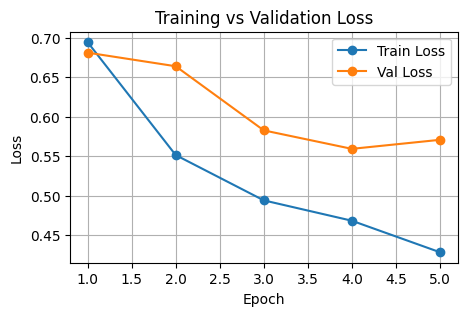

In [22]:
plot_loss_history(history)

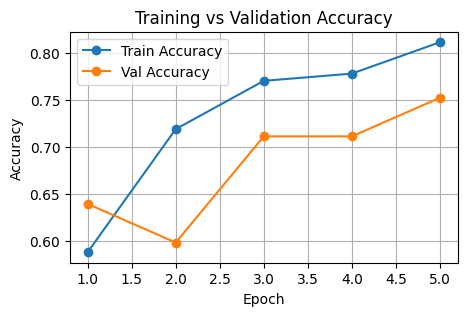

In [23]:
plot_accuracy_history(history)

It looks like validation accuracy may still improving, so we can increase the number of epochs. 

*NOTE:* This very often looks different on different runs. This could be because of a small number of epochs, but may also be a reflection of our small sample size. Cross-val is still an option if we can't find stability at more epochs.

In [13]:
resnet18, loss, optimizer = new_resnet18()
trained_model, history = train_model(resnet18, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Train Loss: 0.9200, Train Acc: 0.4768 | Val Loss: 0.8537, Val Acc: 0.4742
Epoch 2/10 | Train Loss: 0.7257, Train Acc: 0.5284 | Val Loss: 0.7155, Val Acc: 0.5979
Epoch 3/10 | Train Loss: 0.5738, Train Acc: 0.7191 | Val Loss: 0.6777, Val Acc: 0.6907
Epoch 4/10 | Train Loss: 0.4986, Train Acc: 0.7629 | Val Loss: 0.6343, Val Acc: 0.6907
Epoch 5/10 | Train Loss: 0.4941, Train Acc: 0.7603 | Val Loss: 0.6306, Val Acc: 0.6804
Epoch 6/10 | Train Loss: 0.4706, Train Acc: 0.7706 | Val Loss: 0.5845, Val Acc: 0.7423
Epoch 7/10 | Train Loss: 0.4105, Train Acc: 0.8428 | Val Loss: 0.5721, Val Acc: 0.7423
Epoch 8/10 | Train Loss: 0.3978, Train Acc: 0.8402 | Val Loss: 0.5648, Val Acc: 0.7526
Epoch 9/10 | Train Loss: 0.4041, Train Acc: 0.8093 | Val Loss: 0.5433, Val Acc: 0.7938
Epoch 10/10 | Train Loss: 0.3915, Train Acc: 0.8222 | Val Loss: 0.5322, Val Acc: 0.7629


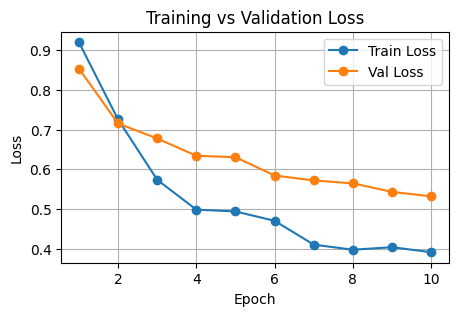

In [14]:
plot_loss_history(history)

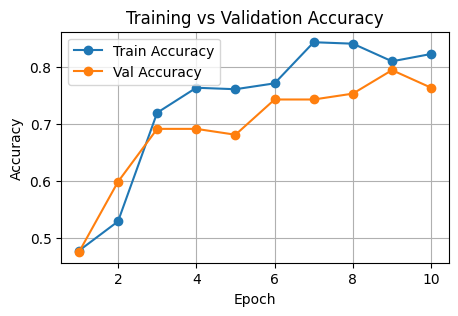

In [15]:
plot_accuracy_history(history)

It looks like it reaches peak performance around epoch 7-9 in terms of validation accuracy and minimal overfitting. Again, note that this looks different across runs, but that is the typical epoch range of convergence. The performance at this epoch looks like this in numbers:

In [16]:
print(f"Epoch 9 - Train Loss: {history['train_loss'][8]:.4f}, Train Acc: {history['train_acc'][8]:.4f} | "
      f"Val Loss: {history['val_loss'][8]:.4f}, Val Acc: {history['val_acc'][8]:.4f}")

Epoch 9 - Train Loss: 0.4041, Train Acc: 0.8093 | Val Loss: 0.5433, Val Acc: 0.7938


~80% validation accuracy seems pretty good for just tuning the final layer. Validation performance is worse than training performance, but not by much -- I don't think overfitting is a big concern. 

*NOTE:* accuracy will be different for every run, and with only 97 validation images, only a couple wrong guesses can move accuracy a lot. for future reference, +-3% or so is probably not very meaningful. It seems okay as long as this is known, but we still may want to do cross-val.

Next steps to squeeze a little more performance out could be tuning the learning rate or unfreezing some of the other layers (training more than just the final layer). Since the loss/accuracy curves look pretty smooth, the learning rate seems to be appropriate enough for now. 

We will try unfreezing the second-to-last layer and see if training those nodes improves performance:

In [17]:
# don't reset the model. use previously trained final layer that we already established is good
model = trained_model   

# unfreeze the last block
for p in model.layer4.parameters():
    p.requires_grad = True

# unfreeze the final fully connected layer
for p in model.fc.parameters():
    p.requires_grad = True

# make new optimizer to include final layer + last block
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5
)

# rerun
model_finetuned, history_finetune = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Train Loss: 0.3629, Train Acc: 0.8531 | Val Loss: 0.5106, Val Acc: 0.7835
Epoch 2/10 | Train Loss: 0.3092, Train Acc: 0.8866 | Val Loss: 0.4959, Val Acc: 0.7835
Epoch 3/10 | Train Loss: 0.2595, Train Acc: 0.9227 | Val Loss: 0.4698, Val Acc: 0.7835
Epoch 4/10 | Train Loss: 0.2300, Train Acc: 0.9356 | Val Loss: 0.4425, Val Acc: 0.8041
Epoch 5/10 | Train Loss: 0.2095, Train Acc: 0.9433 | Val Loss: 0.4329, Val Acc: 0.8041
Epoch 6/10 | Train Loss: 0.1910, Train Acc: 0.9639 | Val Loss: 0.4277, Val Acc: 0.8041
Epoch 7/10 | Train Loss: 0.1603, Train Acc: 0.9742 | Val Loss: 0.4213, Val Acc: 0.8144
Epoch 8/10 | Train Loss: 0.1458, Train Acc: 0.9794 | Val Loss: 0.4222, Val Acc: 0.8351
Epoch 9/10 | Train Loss: 0.1115, Train Acc: 0.9871 | Val Loss: 0.4086, Val Acc: 0.8247
Epoch 10/10 | Train Loss: 0.1044, Train Acc: 0.9897 | Val Loss: 0.4097, Val Acc: 0.8144


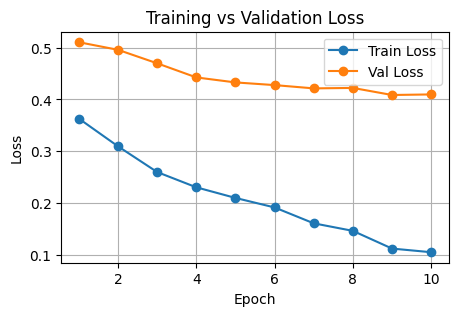

In [18]:
plot_loss_history(history_finetune)

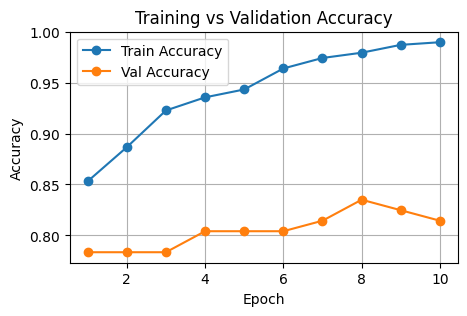

In [19]:
plot_accuracy_history(history_finetune)

In [20]:
best_epoch = np.argmax(history_finetune['val_acc'])
print(f"Best Epoch {best_epoch+1} - Train Loss: {history_finetune['train_loss'][best_epoch]:.4f}, Train Acc: {history_finetune['train_acc'][best_epoch]:.4f} | "
      f"Val Loss: {history_finetune['val_loss'][best_epoch]:.4f}, Val Acc: {history_finetune['val_acc'][best_epoch]:.4f}")

Best Epoch 8 - Train Loss: 0.1458, Train Acc: 0.9794 | Val Loss: 0.4222, Val Acc: 0.8351


The first thing I thought is that there is just much more overfit now. The interesting thing though is that the validation accuracy was still increasing up to epoch 8, the training accuracy just increased more. 

It makes sense that training accuracy would increase so much because we unlocked so many trainable parameters by unfreezing layer 4. Since validation accuracy increased too, there was not necessarily more overfit. 

Apparently these observations are expected in transfer learning, especially with smaller datasets, as the increased number of trainable nodes basically allows the model to memorize the images. This is not always an issue if validation accuracy still increases.

**Overall:** 

- Validation loss improved from 0.45 to 0.36
- Validation accuracy improved from 0.79 to 0.85
- *will be different if rerunning, but somewhere in this range*

So we should consider this our best model for now, but still be concerned with overfit.

## Other Models

Now we can try some other models to see how performance changes with increasing the number of hidden layers.

In [112]:
# function for new resnets
def new_resnet34():
    resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
    in_features = resnet34.fc.in_features
    resnet34.fc = torch.nn.Linear(in_features, 2)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet34.fc.parameters(), lr=1e-3)
    return resnet34, loss, optimizer
def new_resnet50():
    resnet50 = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    in_features = resnet50.fc.in_features
    resnet50.fc = torch.nn.Linear(in_features, 2)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet50.fc.parameters(), lr=1e-3)
    return resnet50, loss, optimizer
def new_resnet101():
    resnet101 = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
    in_features = resnet101.fc.in_features
    resnet101.fc = torch.nn.Linear(in_features, 2)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(resnet101.fc.parameters(), lr=1e-3)
    return resnet101, loss, optimizer

### Resnet34

*Same exact process for fair comparison*

Initial final layer training:

In [114]:
resnet34, criterion, optimizer = new_resnet34()
trained34, history34 = train_model(
    resnet34, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

Epoch 1/10 | Train Loss: 0.7166, Train Acc: 0.5438 | Val Loss: 0.6264, Val Acc: 0.6289
Epoch 2/10 | Train Loss: 0.5635, Train Acc: 0.7062 | Val Loss: 0.5564, Val Acc: 0.7320
Epoch 3/10 | Train Loss: 0.4994, Train Acc: 0.7448 | Val Loss: 0.5275, Val Acc: 0.7835
Epoch 4/10 | Train Loss: 0.4783, Train Acc: 0.7629 | Val Loss: 0.4888, Val Acc: 0.7526
Epoch 5/10 | Train Loss: 0.4197, Train Acc: 0.8015 | Val Loss: 0.5063, Val Acc: 0.7938
Epoch 6/10 | Train Loss: 0.3831, Train Acc: 0.8351 | Val Loss: 0.4711, Val Acc: 0.8041
Epoch 7/10 | Train Loss: 0.3916, Train Acc: 0.8299 | Val Loss: 0.4537, Val Acc: 0.7835
Epoch 8/10 | Train Loss: 0.3735, Train Acc: 0.8222 | Val Loss: 0.4431, Val Acc: 0.7835
Epoch 9/10 | Train Loss: 0.3714, Train Acc: 0.8351 | Val Loss: 0.4835, Val Acc: 0.8144
Epoch 10/10 | Train Loss: 0.3719, Train Acc: 0.8582 | Val Loss: 0.4191, Val Acc: 0.7732


Layer 4 unfreezing:

In [115]:
# don't reset the model. use previously trained final layer that we already established is good
model = trained34   

# unfreeze the last block
for p in model.layer4.parameters():
    p.requires_grad = True

# unfreeze the final fully connected layer
for p in model.fc.parameters():
    p.requires_grad = True

# make new optimizer to include final layer + last block
optimizer = torch.optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5
)

# rerun
model34_finetuned, history34_finetune = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

Epoch 1/10 | Train Loss: 0.3326, Train Acc: 0.8479 | Val Loss: 0.3901, Val Acc: 0.8144
Epoch 2/10 | Train Loss: 0.2338, Train Acc: 0.9330 | Val Loss: 0.3741, Val Acc: 0.8351
Epoch 3/10 | Train Loss: 0.1955, Train Acc: 0.9459 | Val Loss: 0.3612, Val Acc: 0.8144
Epoch 4/10 | Train Loss: 0.1375, Train Acc: 0.9768 | Val Loss: 0.3423, Val Acc: 0.8041
Epoch 5/10 | Train Loss: 0.1139, Train Acc: 0.9845 | Val Loss: 0.3201, Val Acc: 0.7938
Epoch 6/10 | Train Loss: 0.0846, Train Acc: 0.9974 | Val Loss: 0.3108, Val Acc: 0.8144
Epoch 7/10 | Train Loss: 0.0916, Train Acc: 0.9845 | Val Loss: 0.3197, Val Acc: 0.8351
Epoch 8/10 | Train Loss: 0.0671, Train Acc: 1.0000 | Val Loss: 0.2903, Val Acc: 0.8041
Epoch 9/10 | Train Loss: 0.0694, Train Acc: 0.9923 | Val Loss: 0.2687, Val Acc: 0.8454
Epoch 10/10 | Train Loss: 0.0600, Train Acc: 0.9948 | Val Loss: 0.2655, Val Acc: 0.8454


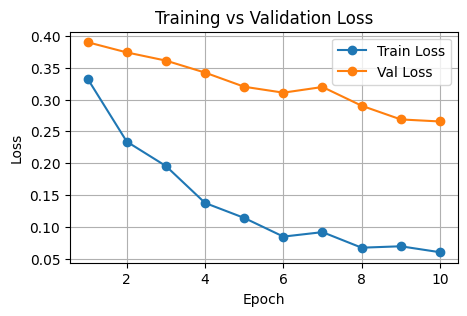

In [116]:
plot_loss_history(history34_finetune)

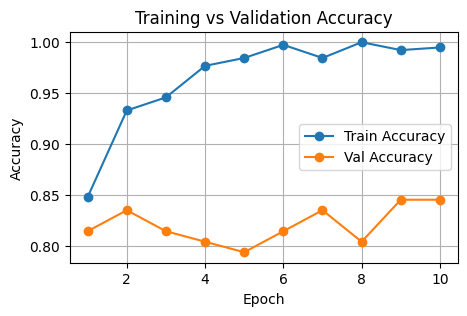

In [117]:
plot_accuracy_history(history34_finetune)

In [118]:
best_epoch = np.argmax(history34_finetune['val_acc'])
print(f"Best Epoch {best_epoch+1} - Train Loss: {history34_finetune['train_loss'][best_epoch]:.4f}, Train Acc: {history34_finetune['train_acc'][best_epoch]:.4f} | "
      f"Val Loss: {history34_finetune['val_loss'][best_epoch]:.4f}, Val Acc: {history34_finetune['val_acc'][best_epoch]:.4f}")

Best Epoch 9 - Train Loss: 0.0694, Train Acc: 0.9923 | Val Loss: 0.2687, Val Acc: 0.8454


Performance did not meaningfully improve with ResNet34, so there is no reason to believe performance will improve with bigger ResNet models. Therefore, we can just end here, and keep our simpler model from before.

## Further Evaluation

Going back to our setup for the ResNet model that we liked, doing some additional performance evaluation.

### Cross-Validation

First, I want to do cross-validation to assess stability. I am concered with only ~100 images in validation being too sensitive to slight changes, so we will see how the perforamnce is on all images through 5-fold cross-validation. 

We will use a similar pipeline that worked well above, except instead of tuning the final layer then unfreezing layer 4 and tuning that too, we will just unfreeze and tune both together. This may affect the learning rate and number of epochs required to converge, but there's no reason to do them separately here because we already know we want to tune both.

In [182]:
def build_new_resnet():

    # load model and set up
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 2)
    
    # freeze all layers
    for p in model.parameters():
        p.requires_grad = False
    
    # unfreeze last conv block + final layer
    for p in model.layer4.parameters():
        p.requires_grad = True
    for p in model.fc.parameters():
        p.requires_grad = True
    
    # loss 
    criterion = torch.nn.CrossEntropyLoss()
    
    # optimizer 
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.Adam(trainable_params, lr=1e-5)
    
    return model, criterion, optimizer

Now a cross validation function:

In [185]:
def run_resnet18_cv(data_root, train_transform, val_transform, K=5, num_epochs=10, batch_size=32, random_state=44):
    
    # base dataset just for paths + labels
    base_dataset = datasets.ImageFolder(root=data_root)  # no transform
    paths  = [s[0] for s in base_dataset.samples]
    labels = np.array([s[1] for s in base_dataset.samples])
    n_samples = len(labels)
    
    # print dataset stats as an update
    print(f"Total images: {n_samples}")
    print(f"Class counts: {np.bincount(labels)}")
    print(f"Classes: {base_dataset.classes}")
    
    # make two full datasets with appropriate transforms (will be subsetted later)
    full_train_dataset = datasets.ImageFolder(root=data_root, transform=train_transform)
    full_val_dataset   = datasets.ImageFolder(root=data_root, transform=val_transform)
    
    # store out-of-fold predictions
    oof_probs = np.zeros((n_samples, 2), dtype=float)
    oof_preds = np.zeros(n_samples, dtype=int)
    fold_accuracies = {}
    
    # loop through CV folds
    skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=random_state)

    for fold, (train_idx, val_idx) in enumerate(skf.split(paths, labels), start=1):

        print(f"\n===== Fold {fold}/{K} =====")
        
        # make train/val subsets
        train_dataset = Subset(full_train_dataset, train_idx)
        val_dataset   = Subset(full_val_dataset,   val_idx)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
        
        # fresh model for this fold
        model, criterion, optimizer = build_new_resnet()
        
        # train the model using the function from before
        trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
        
        # evaluate on validation set with best model state for final OOF predictions
        trained_model.eval()
        val_indices = np.array(val_idx)
        pos = 0
        all_fold_true = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                outputs = trained_model(X_batch)
                probs = torch.softmax(outputs, dim=1)
                preds = probs.argmax(dim=1)
                
                batch_size_actual = X_batch.size(0)
                batch_indices = val_indices[pos:pos+batch_size_actual]
                pos += batch_size_actual
                
                oof_probs[batch_indices] = probs.cpu().numpy()
                oof_preds[batch_indices] = preds.cpu().numpy()
                all_fold_true.append(y_batch.cpu().numpy())
        
        # print fold accuracy as an update
        all_fold_true = np.concatenate(all_fold_true)
        fold_acc = accuracy_score(all_fold_true, oof_preds[val_indices])
        fold_accuracies[fold] = fold_acc
        print(f"Fold {fold} accuracy: {fold_acc:.4f}")
 
    # print overall stats
    print("\n===== Overall CV Results =====")
    cv_acc = accuracy_score(labels, oof_preds)
    print(f"OOF Accuracy: {cv_acc:.4f}")
    print(f"Per-fold accuracies: {fold_accuracies}")
    print(f"Mean +- SD: {np.mean(list(fold_accuracies.values())):.4f} +- {np.std(list(fold_accuracies.values())):.4f}")

    # make dataframe of results with filepaths
    results_df = pd.DataFrame({
        'filepath': paths,
        'true_label': labels,
        'pred_label': oof_preds,
        'prob_class_0': oof_probs[:, 0],
        'prob_class_1': oof_probs[:, 1],
    })
    
    return results_df, fold_accuracies

Run:

In [186]:
preds, fold_accuracies = run_resnet18_cv(
    data_root="data",
    train_transform=train_transform,
    val_transform=val_transform,
    K=5,
    num_epochs=25 # increased because i noticed performance was still improving at the end of the epochs
)

# send to csv so we dont have to rerun it all
preds.to_csv("resnet18_oof_results.csv", index=False)

Total images: 485
Class counts: [256 229]
Classes: ['Alex', 'Kelly']

===== Fold 1/5 =====
Epoch 1/25 | Train Loss: 0.6786, Train Acc: 0.5825 | Val Loss: 0.6322, Val Acc: 0.6082
Epoch 2/25 | Train Loss: 0.5653, Train Acc: 0.7165 | Val Loss: 0.5751, Val Acc: 0.6495
Epoch 3/25 | Train Loss: 0.4940, Train Acc: 0.7835 | Val Loss: 0.5257, Val Acc: 0.7113
Epoch 4/25 | Train Loss: 0.4518, Train Acc: 0.8170 | Val Loss: 0.5025, Val Acc: 0.7526
Epoch 5/25 | Train Loss: 0.4159, Train Acc: 0.8299 | Val Loss: 0.4796, Val Acc: 0.7835
Epoch 6/25 | Train Loss: 0.3838, Train Acc: 0.8582 | Val Loss: 0.4598, Val Acc: 0.7938
Epoch 7/25 | Train Loss: 0.3443, Train Acc: 0.8918 | Val Loss: 0.4429, Val Acc: 0.8041
Epoch 8/25 | Train Loss: 0.3230, Train Acc: 0.8995 | Val Loss: 0.4415, Val Acc: 0.8144
Epoch 9/25 | Train Loss: 0.2982, Train Acc: 0.9098 | Val Loss: 0.4252, Val Acc: 0.8351
Epoch 10/25 | Train Loss: 0.2716, Train Acc: 0.9201 | Val Loss: 0.4229, Val Acc: 0.8144
Epoch 11/25 | Train Loss: 0.2496, Trai

- Consistent performance around 85% accuracy with very low fold-to-fold variance (about +- 1 image)
- The model seems to be converging reliably wtihout overfitting. Train accuracy increases to near perfect, but validation accuracy continues to increases at the same time, so its not a major overfit concern as long as we keep getting that improved validation performance. We see the same thing with loss. 

Now we can use the out-of-fold predictions to do more error analysis.

In [191]:
preds = pd.read_csv("resnet18_oof_results.csv")
preds.sample(5)

,filepath,true_label,pred_label,prob_class_0,prob_class_1
165,data/Alex/Alex-Image241.png,0,0,0.842910,0.157090
360,data/Kelly/Kelly-Image186.png,1,1,0.044893,0.955107
387,data/Kelly/Kelly-Image210.png,1,1,0.003597,0.996403
247,data/Alex/Alex-Image91.png,0,0,0.969057,0.030943
5,data/Alex/Alex-Image06.png,0,0,0.696709,0.303291


Confusion Matrix:

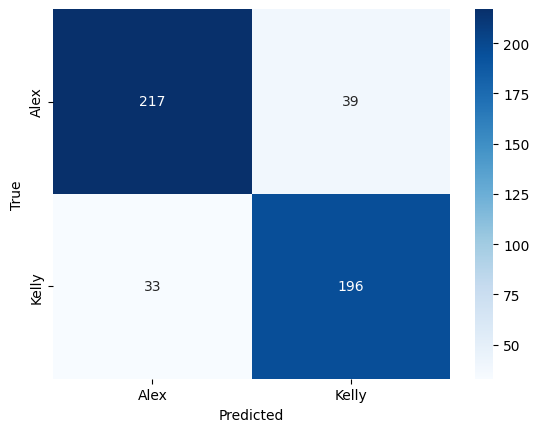

In [193]:
cm = confusion_matrix(preds['true_label'], preds['pred_label'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Alex','Kelly'],
            yticklabels=['Alex','Kelly'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Very symmetric. The model predicts each class at a similar rate and also makes mistakes at a similar rate. Specifically:

In [195]:
for cls in [0, 1]:
    mask = preds['true_label'] == cls
    acc = (preds.loc[mask, 'pred_label'] == cls).mean()
    print(f"Accuracy for class {cls}: {acc:.3f}")

Accuracy for class 0: 0.848
Accuracy for class 1: 0.856


Get low confidence correct predictions and high confidence wrong predictions to manually investigate what images the model struggles with:

In [200]:
preds['max_prob'] = preds[['prob_class_0', 'prob_class_1']].max(axis=1)
low_conf_correct = preds[(preds['pred_label']==preds['true_label'])].nsmallest(10, 'max_prob')
high_conf_wrong = preds[(preds['pred_label']!=preds['true_label'])].nlargest(10, 'max_prob')

# print low confidence correct file paths
print("====================== Low Confidence Correct Predictions: ======================")
for idx, row in low_conf_correct.iterrows():
    print(f"File: {row['filepath']}, True: {row['true_label']}, Pred: {row['pred_label']}, Prob: {row['max_prob']:.4f}")
print("\n====================== High Confidence Wrong Predictions: ======================")
for idx, row in high_conf_wrong.iterrows():
    print(f"File: {row['filepath']}, True: {row['true_label']}, Pred: {row['pred_label']}, Prob: {row['max_prob']:.4f}")

====================== Low Confidence Correct Predictions: ======================
File: data/Kelly/Kelly-Image211.png, True: 1, Pred: 1, Prob: 0.5003
File: data/Kelly/Kelly-Image90.png, True: 1, Pred: 1, Prob: 0.5052
File: data/Alex/Alex-Image255.png, True: 0, Pred: 0, Prob: 0.5057
File: data/Kelly/Kelly-Image100.png, True: 1, Pred: 1, Prob: 0.5079
File: data/Kelly/Kelly-Image102.png, True: 1, Pred: 1, Prob: 0.5119
File: data/Alex/Alex-Image105.png, True: 0, Pred: 0, Prob: 0.5149
File: data/Kelly/Kelly-Image66.png, True: 1, Pred: 1, Prob: 0.5157
File: data/Kelly/Kelly-Image181.png, True: 1, Pred: 1, Prob: 0.5172
File: data/Alex/Alex-Image52.png, True: 0, Pred: 0, Prob: 0.5196
File: data/Kelly/Kelly-Image113.png, True: 1, Pred: 1, Prob: 0.5242

====================== High Confidence Wrong Predictions: ======================
File: data/Alex/Alex-Image68.png, True: 0, Pred: 1, Prob: 0.9808
File: data/Kelly/Kelly-Image30.png, True: 1, Pred: 0, Prob: 0.9769
File: data/Kelly/Kelly-Image188.p

### High Confidence Wrong Predictions

Initially, I would guess that these mistakes are caused by Kelly having a photo that looks a lot like Alex's photos or vice versa.

Upon actually looking ...

### Low Confidence Correct Predictions

I would guess that the low confidence is caused by poor image quality (lighting, color, etc.) that makes it hard for the model to extract information. 

Upon actually looking ...

# Holdout Prediction

If we are comfortable with our model as we have it, the last step is to apply the same process to the entire dataset, and then predict on the unlabeled holdout set.

The model will not be the exact same (in terms of actual weights) as what we had before because we were re-tuning on each cross-validation fold, and now we are tuning on the entire dataset all at once. However, we should expect something similar because the fold performance was so stable. 

We also need a new train_model function because we can't use a validation set here. But it will essentially be the same:

In [201]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs):

    # loop through each epoch keeping track of performance
    history = {'train_loss': [], 'train_acc': []}
    for epoch in range(num_epochs):

        # all same training process as before
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            preds = outputs.argmax(dim=1)
            running_loss += loss.item() * X_batch.size(0)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        # no validation phase this time

    # no best_state here because no validation. just use the model at the last epoch
    return model, history

Fit model on all labeled data:

In [210]:
# apply training transformations to the entire dataset
train_dataset = datasets.ImageFolder("Data", transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# build and train final model on full dataset
model, criterion, optimizer = build_new_resnet()
final_model, final_history = train_final_model(
    model, train_loader, criterion, optimizer, num_epochs=25
)

Epoch 1/25 | Train Loss: 0.6844, Train Acc: 0.5876
Epoch 2/25 | Train Loss: 0.5511, Train Acc: 0.7361
Epoch 3/25 | Train Loss: 0.4798, Train Acc: 0.7649
Epoch 4/25 | Train Loss: 0.4355, Train Acc: 0.8186
Epoch 5/25 | Train Loss: 0.3901, Train Acc: 0.8227
Epoch 6/25 | Train Loss: 0.3693, Train Acc: 0.8536
Epoch 7/25 | Train Loss: 0.3201, Train Acc: 0.8928
Epoch 8/25 | Train Loss: 0.3022, Train Acc: 0.8825
Epoch 9/25 | Train Loss: 0.2745, Train Acc: 0.9216
Epoch 10/25 | Train Loss: 0.2449, Train Acc: 0.9340
Epoch 11/25 | Train Loss: 0.2538, Train Acc: 0.9216
Epoch 12/25 | Train Loss: 0.2143, Train Acc: 0.9567
Epoch 13/25 | Train Loss: 0.1964, Train Acc: 0.9567
Epoch 14/25 | Train Loss: 0.1766, Train Acc: 0.9691
Epoch 15/25 | Train Loss: 0.1796, Train Acc: 0.9649
Epoch 16/25 | Train Loss: 0.1412, Train Acc: 0.9835
Epoch 17/25 | Train Loss: 0.1302, Train Acc: 0.9876
Epoch 18/25 | Train Loss: 0.1257, Train Acc: 0.9814
Epoch 19/25 | Train Loss: 0.1208, Train Acc: 0.9794
Epoch 20/25 | Train L

Predict on holdout data:

In [211]:
# retain class names for later
class_names = train_dataset.classes

# list all image files
holdout_folder = "HoldoutSet01"
holdout_files = [
    f for f in os.listdir(holdout_folder)
    if f.lower().endswith((".png", ".jpg", ".jpeg"))
]

# set to eval mode
final_model.eval()

filenames = []
pred_indices = []
pred_labels = []
prob_class1 = []   # prob of class index 1 ('Kelly')
prob_class0 = []   # prob of class index 2 ('Alex')

# use no_grad to not store gradients during inference
with torch.no_grad():

    # loop through each image because we cant build a dataset easily here
    for fname in sorted(holdout_files):

        # load image and mimic what ImageFolder did
        path = os.path.join(holdout_folder, fname)
        img = Image.open(path).convert("RGB")
        x = val_transform(img).unsqueeze(0)

        # forward pass
        outputs = final_model(x)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = probs.argmax(dim=1).item()
        prob1 = probs[0, 1].item()
        prob0 = probs[0, 0].item()

        # accumulate results
        filenames.append(fname)
        pred_indices.append(pred_idx)
        pred_labels.append(class_names[pred_idx])
        prob_class1.append(prob1)
        prob_class0.append(prob0)

# make df
holdout_df = pd.DataFrame({
    "filename": filenames,
    "predicted_class": pred_indices,
    "predicted_label": pred_labels,
    f"prob_{class_names[1]}": prob_class1,
    f"prob_{class_names[0]}": prob_class0
})

holdout_df.to_csv("HoldoutSet01_predictions.csv", index=False)
holdout_df.head()

,filename,predicted_class,predicted_label,prob_Kelly,prob_Alex
0,TestSetImage01.png,1,Kelly,0.897775,0.102225
1,TestSetImage02.png,1,Kelly,0.696009,0.303991
2,TestSetImage03.png,0,Alex,0.243032,0.756968
3,TestSetImage04.png,1,Kelly,0.977858,0.022142
4,TestSetImage05.png,0,Alex,0.377363,0.622636


In [215]:
holdout_df.predicted_label.value_counts()

predicted_label
Alex     11
Kelly     9
Name: count, dtype: int64

In [216]:
# print average confidence for each class
for cls in class_names:
    mask = holdout_df['predicted_label'] == cls
    avg_prob = holdout_df.loc[mask, f'prob_{cls}'].mean()
    print(f"Average predicted probability for class '{cls}': {avg_prob:.4f}")

Average predicted probability for class 'Alex': 0.7961
Average predicted probability for class 'Kelly': 0.8969


In [224]:
# print the highest confidence predictions for each class
for cls in class_names:
    mask = holdout_df['predicted_label'] == cls
    top_preds = holdout_df.loc[mask].nsmallest(3, f'prob_{cls}')
    print(f"\nLowest confidence predictions for class '{cls}':")
    for idx, row in top_preds.iterrows():
        print(f"File: {row['filename']}, Predicted Label: {row['predicted_label']}, Probability: {row[f'prob_{cls}']:.4f}")


Lowest confidence predictions for class 'Alex':
File: TestSetImage16.png, Predicted Label: Alex, Probability: 0.5095
File: TestSetImage20.png, Predicted Label: Alex, Probability: 0.5930
File: TestSetImage05.png, Predicted Label: Alex, Probability: 0.6226

Lowest confidence predictions for class 'Kelly':
File: TestSetImage18.png, Predicted Label: Kelly, Probability: 0.6218
File: TestSetImage02.png, Predicted Label: Kelly, Probability: 0.6960
File: TestSetImage01.png, Predicted Label: Kelly, Probability: 0.8978
